In [28]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import googlemaps
from os import getenv

gmaps = googlemaps.Client(key=getenv("GMAPS_API_KEY"))

fasttext_vectors = KeyedVectors.load("fastvec.bin")

In [41]:
users = [
    {"id": 1, "name": "Alice", "latitude": 50.8501, "longitude": 4.3517, "playlist": ["rock"], "can_be_driver": True},
    {"id": 2, "name": "Bob", "latitude": 50.8467, "longitude": 4.3524, "playlist": ["rock", "pop-rock", "classic-rock"], "can_be_driver": False},
    {"id": 3, "name": "Charlie", "latitude": 50.8533, "longitude": 4.3571, "playlist": ["rap", "hip-hop", "pop-rap"], "can_be_driver": False},
    {"id": 4, "name": "Diana", "latitude": 50.8400, "longitude": 4.3602, "playlist": ["folk-pop", "jazz", "blues"], "can_be_driver": False},
    {"id": 5, "name": "Eve", "latitude": 50.8550, "longitude": 4.3483, "playlist": ["pop", "neo-mellow", "latin"], "can_be_driver": False},
    {"id": 6, "name": "Frank", "latitude": 50.8591, "longitude": 4.3625, "playlist": ["rock", "alternative-rock", "punk"], "can_be_driver": True},
    {"id": 7, "name": "Grace", "latitude": 50.8520, "longitude": 4.3545, "playlist": ["pop", "edm", "dance-pop"], "can_be_driver": False},
    {"id": 8, "name": "Hank", "latitude": 50.8472, "longitude": 4.3512, "playlist": ["folk", "acoustic", "country"], "can_be_driver": False},
    {"id": 9, "name": "Ivy", "latitude": 50.8600, "longitude": 4.3550, "playlist": ["rap", "trap-music", "hip-hop"], "can_be_driver": False},
    {"id": 10, "name": "Jack", "latitude": 50.8480, "longitude": 4.3520, "playlist": ["pop", "latin", "r&b"], "can_be_driver": True},
    {"id": 11, "name": "Kate", "latitude": 50.8510, "longitude": 4.3560, "playlist": ["classic-rock", "metal", "hard-rock"], "can_be_driver": False},
    {"id": 12, "name": "Leo1", "latitude": 50.8494, "longitude": 4.3598, "playlist": ["rock", "blues", "swing"], "can_be_driver": False},
    {"id": 13, "name": "Leo2", "latitude": 50.8490, "longitude": 4.3590, "playlist": ["jazz", "blues", "swing"], "can_be_driver": False},
]

# Sample drivers
drivers = [
    {"id": 13, "name": "Driver1", "latitude": 50.8501, "longitude": 4.3517, "max_capacity": 4, "pickup_radius": 1, "playlist": ["rock"]},]

In [42]:
def fetch_distance_matrix(users, drivers, batch_size=10):
    origins = [(user['latitude'], user['longitude']) for user in users]
    destinations = [(driver['latitude'], driver['longitude']) for driver in drivers]
    distance_matrix = np.full((len(users), len(drivers)), float('inf'))

    for i in range(0, len(origins), batch_size):
        batch_origins = origins[i:i + batch_size]
        response = gmaps.distance_matrix(batch_origins, destinations, mode="driving")
        for row_idx, row in enumerate(response['rows']):
            for col_idx, element in enumerate(row['elements']):
                if 'distance' in element:
                    distance_matrix[i + row_idx, col_idx] = element['distance']['value']
    return distance_matrix



def calculate_music_similarity(users, drivers):
    def get_playlist_embedding(playlist):
        vectors = [fasttext_vectors[genre] for genre in playlist if genre in fasttext_vectors]
        return np.mean(vectors, axis=0) if vectors else np.zeros(fasttext_vectors.vector_size)

    user_embeddings = [get_playlist_embedding(user["playlist"]) for user in users]
    driver_embeddings = [get_playlist_embedding(driver["playlist"]) for driver in drivers]
    return cosine_similarity(user_embeddings, driver_embeddings)



def assign_users(users, drivers, distance_matrix, music_similarity_matrix, location_weight, music_weight):
    """
    Assign users to drivers based on proximity and music preferences, prioritizing closer users,
    and log the distances between drivers and their assigned passengers. Dynamically promote users
    to drivers if necessary, ensuring the loop terminates when no further improvements are possible.
    """
    while True:
        combined_scores = np.zeros_like(distance_matrix)
        driver_capacities = [driver["max_capacity"] for driver in drivers]

        # Log distances between drivers and passengers
        group_distances = {driver["name"]: [] for driver in drivers}

        # Calculate combined scores for each user-driver pair
        for user_idx, user in enumerate(users):
            for driver_idx, driver in enumerate(drivers):
                if distance_matrix[user_idx][driver_idx] <= driver["pickup_radius"] * 1000:  # Within pickup radius
                    location_score = 1 - (distance_matrix[user_idx][driver_idx] / np.max(distance_matrix))
                    music_score = music_similarity_matrix[user_idx][driver_idx]
                    combined_scores[user_idx][driver_idx] = (
                        location_weight * location_score + music_weight * music_score
                    )

        # Sort users by proximity to their closest driver
        user_distances = [
            (user_idx, min(distance_matrix[user_idx])) for user_idx in range(len(users))
        ]
        user_distances.sort(key=lambda x: x[1])  # Closest users first

        # Assign users to drivers
        outliers = []
        for user_idx, _ in user_distances:
            valid_drivers = [
                driver_idx for driver_idx, driver in enumerate(drivers)
                if distance_matrix[user_idx][driver_idx] <= driver["pickup_radius"] * 1000
            ]

            if valid_drivers:
                # Assign to the driver with the highest combined score
                best_driver_idx = max(valid_drivers, key=lambda idx: combined_scores[user_idx][idx])
                if driver_capacities[best_driver_idx] > 0:
                    users[user_idx]["assigned_driver"] = drivers[best_driver_idx]["name"]
                    users[user_idx]["assigned_driver_index"] = best_driver_idx
                    driver_capacities[best_driver_idx] -= 1

                    # Log distance between user and driver
                    group_distances[drivers[best_driver_idx]["name"]].append(
                        distance_matrix[user_idx][best_driver_idx] / 1000  # Convert to kilometers
                    )
                else:
                    users[user_idx]["assigned_driver"] = "outlier"
                    users[user_idx]["assigned_driver_index"] = -1
                    outliers.append(users[user_idx])
            else:
                users[user_idx]["assigned_driver"] = "outlier"
                users[user_idx]["assigned_driver_index"] = -1
                outliers.append(users[user_idx])

        # If no outliers remain, exit the loop
        if not outliers:
            break

        # Identify eligible users to promote to drivers
        eligible_users = [
            user for user in users if user.get("can_be_driver", False) and user["assigned_driver"] == "outlier"
        ]

        # Promote the best candidate to a driver
        if eligible_users:
            best_candidate = None
            max_coverage = 0

            for candidate in eligible_users:
                # Count how many outliers are within this candidate's radius
                candidate_distances = fetch_distance_matrix([candidate], outliers)[0]
                coverage_count = sum(
                    1 for distance in candidate_distances if distance <= 2000  # 2 km radius
                )

                if coverage_count > max_coverage:
                    best_candidate = candidate
                    max_coverage = coverage_count

            if best_candidate and max_coverage > 0:
                new_driver = {
                    "id": len(drivers) + 1,
                    "name": f"NewDriver_{best_candidate['name']}",
                    "latitude": best_candidate["latitude"],
                    "longitude": best_candidate["longitude"],
                    "max_capacity": 3,  # Default capacity for new drivers
                    "pickup_radius": 2,  # Default pickup radius
                    "playlist": best_candidate["playlist"],
                }
                drivers.append(new_driver)

                # Remove the promoted user from the users list
                user_index = users.index(best_candidate)
                users.pop(user_index)

                # Update distance and similarity matrices to remove the promoted user
                distance_matrix = np.delete(distance_matrix, user_index, axis=0)
                music_similarity_matrix = np.delete(music_similarity_matrix, user_index, axis=0)

                # Update the promoted user
                best_candidate["assigned_driver"] = f"NewDriver_{best_candidate['name']}"
                best_candidate["assigned_driver_index"] = len(drivers) - 1

                # Update distance and music similarity matrices for the new driver
                new_driver_distances = fetch_distance_matrix(users, [new_driver])[:, 0]
                new_driver_music_similarity = calculate_music_similarity(users, [new_driver])[:, 0]
                distance_matrix = np.column_stack((distance_matrix, new_driver_distances))
                music_similarity_matrix = np.column_stack((music_similarity_matrix, new_driver_music_similarity))
            else:
                # If no eligible user can cover outliers, exit the loop
                break
        else:
            # If no eligible users exist, exit the loop
            break

    return users, driver_capacities, group_distances



distance_matrix = fetch_distance_matrix(users, drivers)
music_similarity_matrix = calculate_music_similarity(users, drivers)
updated_users, remaining_capacities, group_distances = assign_users(users, drivers, distance_matrix, music_similarity_matrix, location_weight=0.9,  music_weight=0.1)


print("\nDriver-Passenger Distances (km):")
for driver, distances in group_distances.items():
    print(f"{driver}: {distances}")



Driver-Passenger Distances (km):
Driver1: [0.0, 0.58, 0.877, 0.94]
NewDriver_Jack: [0.0, 0.627, 1.888]
NewDriver_Frank: [0.618, 0.895, 1.303]


In [40]:
def calculate_distance_with_google(user1, user2):
    try:
        # Format origins and destinations
        origins = f"{user1['latitude']},{user1['longitude']}"
        destinations = f"{user2['latitude']},{user2['longitude']}"

        # Request distance matrix
        result = gmaps.distance_matrix(origins, destinations, mode="driving")

        # Extract the distance in meters
        distance_meters = result['rows'][0]['elements'][0].get('distance', {}).get('value')

        if distance_meters is not None:
            # Convert meters to kilometers
            return distance_meters / 1000
        else:
            print("Distance data not available.")
            return None
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None
    

calculate_distance_with_google(drivers[0], users[4])

3.067

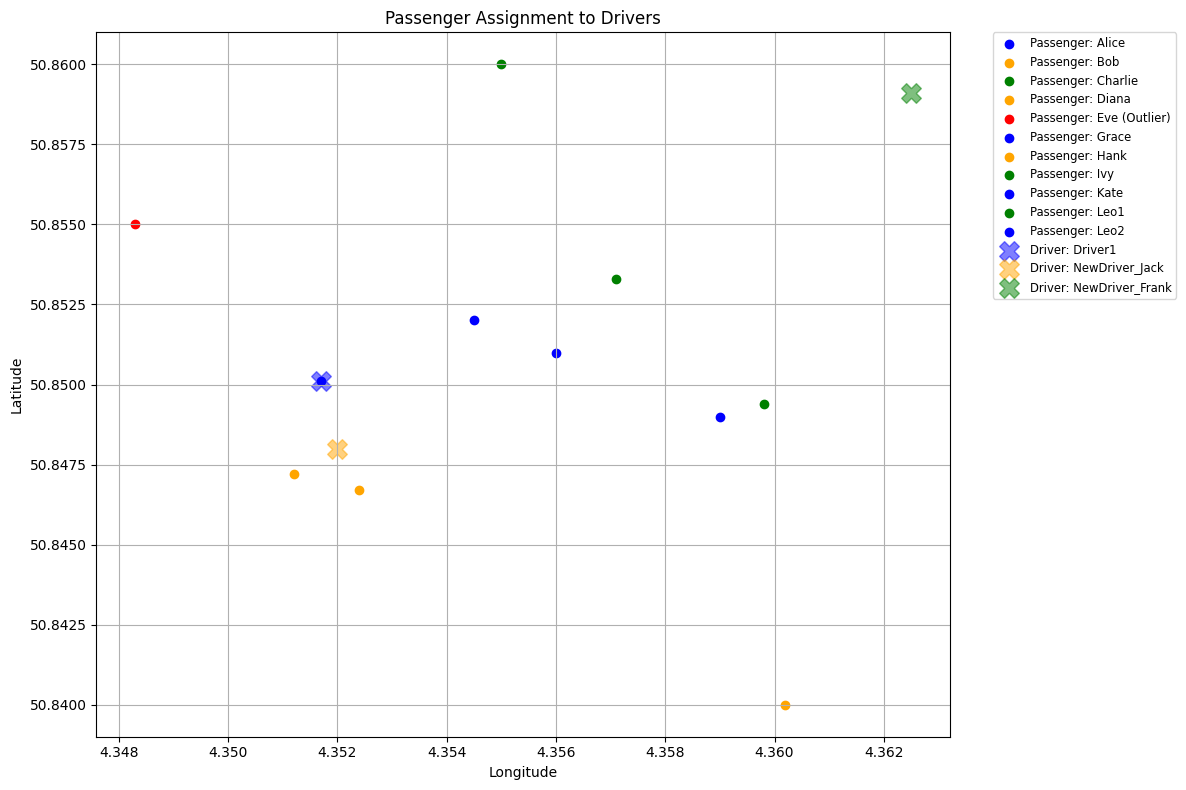

In [43]:
def plot_clusters_with_outliers(users, drivers):
    """
    Plot users and drivers on a larger chart, highlighting assignments and outliers.
    :param users: List of users with 'latitude', 'longitude', and 'assigned_driver'.
    :param drivers: List of drivers with latitude, longitude, and max_capacity.
    """
    # Define a list of colors for different drivers (expandable)
    colors = ['blue', 'orange', 'green', 'purple', 'pink', 'cyan', 'yellow', 'brown', 'lime', 'teal']

    # Dynamically assign colors to drivers, ensuring the list can accommodate all drivers
    color_map = {i: colors[i % len(colors)] for i in range(len(drivers))}

    # Set the figure size (scale of the plot)
    plt.figure(figsize=(12, 8))  # Adjust width and height as needed

    # Plot passengers
    for user in users:
        if user['assigned_driver'] == 'outlier':
            plt.scatter(user['longitude'], user['latitude'], c='red', label=f"Passenger: {user['name']} (Outlier)")
        else:
            driver_index = user['assigned_driver_index']
            plt.scatter(user['longitude'], user['latitude'], c=color_map[driver_index], label=f"Passenger: {user['name']}")

    # Plot drivers with semi-transparency
    for i, driver in enumerate(drivers):
        plt.scatter(
            driver['longitude'], 
            driver['latitude'], 
            c=color_map[i], 
            marker='X', 
            s=200, 
            alpha=0.5,  # Semi-transparent
            label=f"Driver: {driver['name']}"
        )

    # Add labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Passenger Assignment to Drivers")
    plt.grid(True)

    # Place the legend outside the chart area
    plt.legend(loc="upper left", fontsize='small', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Adjust layout to fit the legend
    plt.tight_layout()
    plt.show()



plot_clusters_with_outliers(updated_users, drivers)